In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch

c:\Users\peaks\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("Bingsu/Cat_and_Dog")

Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 26597.91 examples/s]


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2000
    })
})

In [7]:
id2label = {}
for i, label in enumerate(dataset["train"].features["labels"].names):
  id2label[i] = label

In [8]:
id2label

{0: 'cat', 1: 'dog'}

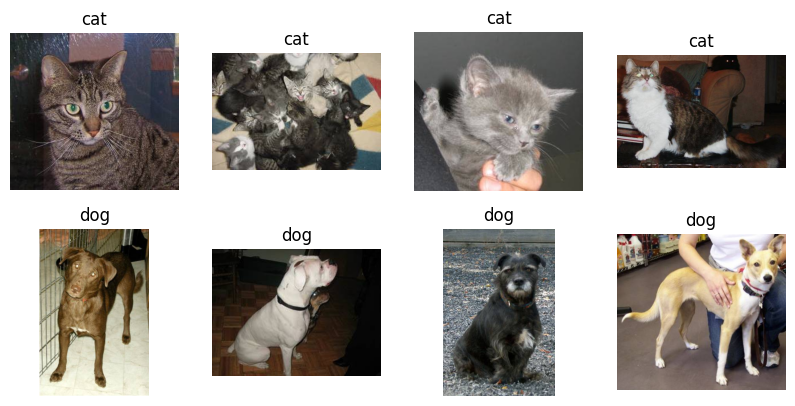

In [11]:
rows = 4; cols = 4
fig = plt.figure(figsize=(10, 10))
c = 0
for i in range(0, 8000, 1000):
  ax = fig.add_subplot(rows, cols, c+1)
  image = dataset["train"][i]["image"]
  plt.imshow(image)
  plt.axis('off')
  plt.title(id2label[dataset["train"][i]["labels"]])
  c+=1
plt.show()

In [12]:
import open_clip

In [13]:
model_name = 'RN50-quickgelu'
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms(model_name,
                                                             device = device,
                                                             pretrained='openai')
tokenizer = open_clip.get_tokenizer(model_name)

In [14]:
def extract_embeddings(model: torch.nn.Module):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    def extract(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [preprocess(image).cuda() for image in images]
        )
        new_batch = image_batch_transformed.to(device)
        with torch.no_grad():
            embeddings = model.encode_image(image_batch_transformed)
            embeddings /= embeddings.norm(dim=-1, keepdim=True)
        return {"embeddings": embeddings}

    return extract

In [16]:
x = dataset['train']['image'][0]

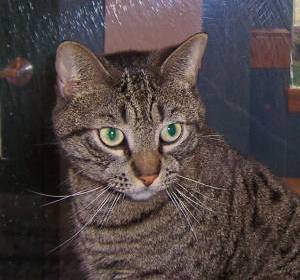

In [17]:
x

In [19]:
X = preprocess(x)

In [22]:
X.shape

torch.Size([3, 224, 224])

In [23]:
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model)
candidate_subset_emb = dataset['train'].map(extract_fn, batched=True, batch_size=24)

Map: 100%|██████████| 8000/8000 [00:47<00:00, 169.98 examples/s]


In [25]:
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)
    candidate_ids.append(entry)

print("Sample first indexing: ", candidate_ids[0])

100%|██████████| 8000/8000 [00:09<00:00, 853.55it/s]

Sample first indexing:  0_0


In [26]:
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings).double()

print("Check embedding shape: ", all_candidate_embeddings.shape)

Check embedding shape:  torch.Size([8000, 1024])


In [27]:
def fetch_clip_similar(features, top_k=5):
  similarity = (100 * all_candidate_embeddings @ features.T ).softmax(dim=0)

  search_result = {}
  for i, sim in enumerate(similarity.detach().numpy()):
    search_result[candidate_ids[i]] = sim[0]
  similarity_mapping_sorted = dict(sorted(search_result.items(),
                                          key=lambda x: x[1],
                                          reverse=True))
  id_entries = list(similarity_mapping_sorted.keys())[:top_k]

  ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
  labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
  return ids, labels

In [63]:

prompt = "white"
text = tokenizer([prompt]).cuda()
text_feature = model.encode_text(text)
text_feature /= text_feature.norm(dim=-1, keepdim=True)
text_feature = text_feature.type(torch.DoubleTensor)

print("Check text feature shape: ", text_feature.shape)

Check text feature shape:  torch.Size([1, 1024])


In [64]:
sim_text_ids, sim_text_labels = fetch_clip_similar(text_feature)
print(f"Query prompt: {prompt}")
print(f"Top 5 candidate labels: {sim_text_labels}")

Query prompt: white
Top 5 candidate labels: [0, 1, 0, 1, 0]


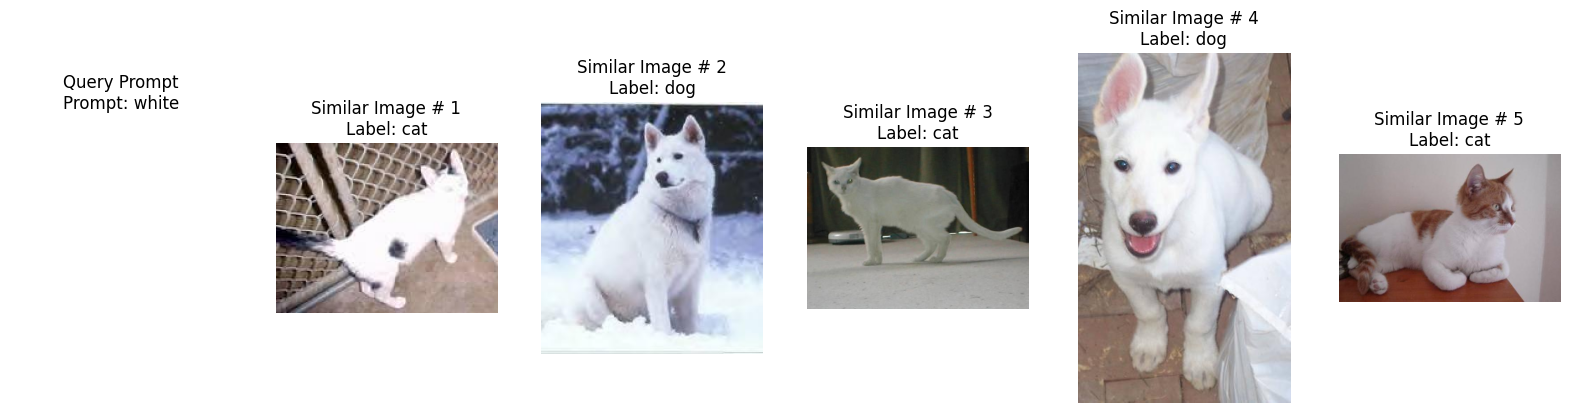

In [65]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = labels[i]
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Prompt\n" + f"Prompt: {label_id}")
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[int(label_id)])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")

images = []
labels = []

for id, label in zip(sim_text_ids, sim_text_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

test_sample = np.zeros([100,100,3], dtype=np.uint8); test_sample.fill(255)
images.insert(0, test_sample)
labels.insert(0, prompt)
plot_images(images, labels)

Search for -  dog


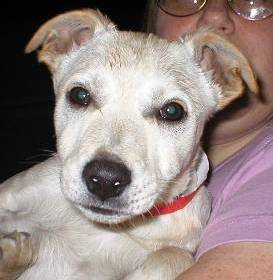

In [68]:
test_idx = 1234
# Random - test_idx = np.random.choice(len(dataset["validation"]))

test_sample = dataset["test"][test_idx]["image"]
test_label = dataset["test"][test_idx]["labels"]
print("Search for - ", id2label[test_label])

test_sample

In [69]:
image_prompt = image = preprocess(test_sample).cuda().unsqueeze(0)
image_feature = model.encode_image(image_prompt)
image_feature /= image_feature.norm(dim=-1, keepdim=True)
image_feature = image_feature.type(torch.DoubleTensor)

print("Check image feature shape: ", image_feature.shape)

Check image feature shape:  torch.Size([1, 1024])


In [70]:
sim_image_ids, sim_image_labels = fetch_clip_similar(image_feature)
print(f"Query Image Prompt: {test_label}")
print(f"Top 5 candidate labels: {sim_image_labels}")

Query Image Prompt: 1
Top 5 candidate labels: [1, 1, 1, 1, 1]


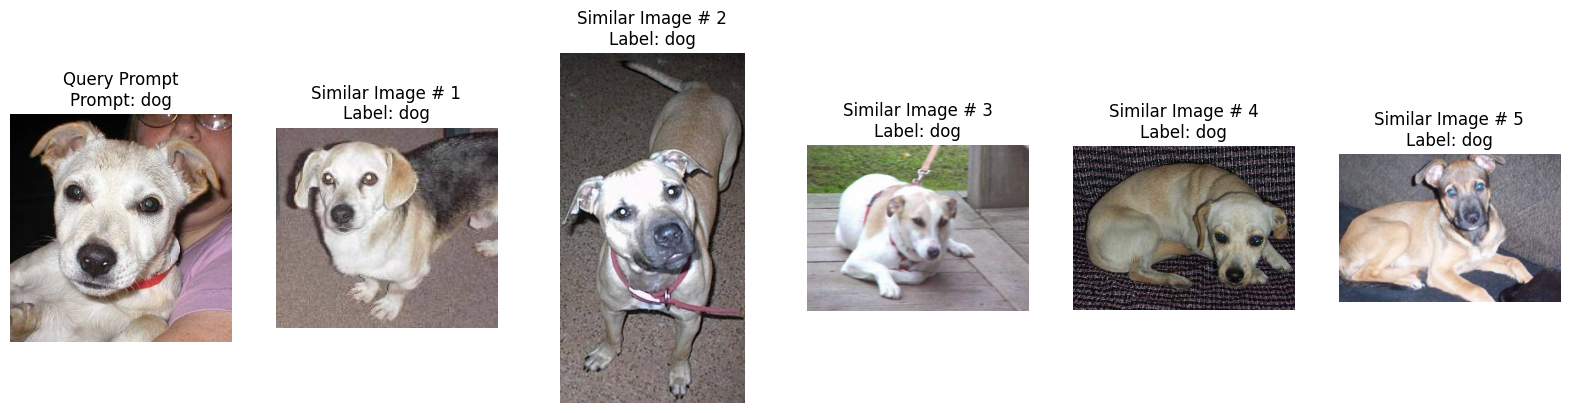

In [72]:
images = []; labels = []

for id, label in zip(sim_image_ids, sim_image_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, id2label[test_label])
plot_images(images, labels)